# Import

In [1]:
import matplotlib.pyplot as plt
from os.path import join
from matplotlib.ticker import FuncFormatter, MultipleLocator, StrMethodFormatter, ScalarFormatter
import matplotlib as mpl

from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import sys, gc
sys.path.append('..')
from Class.PlotConfig import *

In [3]:
import seaborn as sns

sns.set(font_scale = 2.5)
sns.set_style("white") 

# Input

## Attention

In [4]:
root = '../scratch/TFT_baseline/figures/'
attention = pd.read_csv(join(root, 'attention.csv'))
attention['Date'] = pd.to_datetime(attention['Date'])
attention.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Date,FIPS
0,0.005,0.022,0.177,0.004,0.008,0.038,0.490,0.093,0.067,0.069,0.003,0.007,0.018,2020-03-13,10001
1,0.129,0.001,0.010,0.057,0.023,0.101,0.336,0.089,0.001,0.009,0.062,0.026,0.155,2020-03-14,10001
2,0.091,0.018,0.003,0.006,0.150,0.064,0.395,0.041,0.008,0.002,0.004,0.131,0.088,2020-03-15,10001


In [5]:
max_encoder_length = 13
encoder_indices = list(range(max_encoder_length))
attention.rename(
    {str(index):index for index in encoder_indices}, 
    axis=1, inplace=True
)

attention_date_aligned = pd.DataFrame(attention[['FIPS', 'Date']])
for i in range(max_encoder_length):
    attention_date_aligned[i] = attention[i].shift(
        periods=i-max_encoder_length, fill_value=0
    )

In [6]:
attention_date_aligned_summed = attention_date_aligned.groupby('FIPS')[
    encoder_indices
].aggregate('sum').reset_index()

attention_date_aligned_mean = attention_date_aligned.groupby('FIPS')[
    encoder_indices
].aggregate('mean').reset_index()

gc.collect()

0

In [7]:
attention_date_aligned_summed['sum'] = attention_date_aligned_summed[encoder_indices].sum(axis=1)
attention_date_aligned_mean['mean'] = attention_date_aligned_mean[encoder_indices].mean(axis=1)

## Predictions

In [8]:
predictions = pd.read_csv(join(root, 'predictions.csv'))
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions['weekday'] = predictions.Date.dt.dayofweek

# analyzing against train attention weights
predictions = predictions[predictions['split']=='train']

predictions_summed_by_county = predictions.groupby(
    ['FIPS'])[['Cases']].aggregate('sum').reset_index()

predictions.head(3)

,FIPS,TimeFromStart,Predicted_Cases,Cases,Date,split,weekday
0,10001,13,7.0,0.0,2020-03-13,train,4
1,10003,13,17.0,0.0,2020-03-13,train,4
2,10005,13,9.0,0.0,2020-03-13,train,4


## Social Vulnerability Index

In [9]:
svi = pd.read_csv('../../dataset_raw/Support files/SVI2020_US_COUNTY.csv')
svi['density'] = svi['E_TOTPOP'] / svi['AREA_SQMI']
svi.describe()

,ST,STCNTY,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_LIMENG,M_LIMENG,E_MINRTY,M_MINRTY,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,EP_HBURD,MP_HBURD,EP_NOHSDP,MP_NOHSDP,EP_UNINSUR,MP_UNINSUR,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_LIMENG,MP_LIMENG,EP_MINRTY,MP_MINRTY,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV150,EPL_UNEMP,EPL_HBURD,EPL_NOHSDP,EPL_UNINSUR,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_LIMENG,SPL_THEME2,RPL_THEME2,EPL_MINRTY,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV150,F_UNEMP,F_HBURD,F_NOHSDP,F_UNINSUR,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_LIMENG,F_THEME2,F_MINRTY,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_DAYPOP,E_NOINT,M_NOINT,E_AFAM,M_AFAM,E_HISP,M_HISP,E_ASIAN,M_ASIAN,E_AIAN,M_AIAN,E_NHPI,M_NHPI,E_TWOMORE,M_TWOMORE,E_OTHERRACE,M_OTHERRACE,EP_NOINT,MP_NOINT,EP_AFAM,MP_AFAM,EP_HISP,MP_HISP,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,density
count,3143.000000,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.00000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30.271079,30374.576519,30374.576519,1124.096939,1.039037e+05,7.750875,4.404478e+04,129.369074,3.892912e+04,404.629653,2.142605e+04,1137.330576,2822.308622,301.958320,1.058763e+04,527.012727,8.133210e+03,482.360802,8927.426981,654.895323,1.666014e+04,72.392619,2.332063e+04,45.889596,1.297692e+04,627.700286,2509.951639,262.701559,4.061988e+03,293.966911,4.146291e+04,958.423481,6047.581610,289.320395,2664.504932,280.972956,1291.965956,164.551702,3291.288896,259.593064,2568.671333,269.246580,24.486828,3.129749,5.197996,1.635794,22.282342,3.216577,12.395514,1.902418,9.539548,1.846134,19.227935,0.584951,22.083710,0.510340,15.991505,1.828985,5.879033,1.697168,1.621540,0.867579,24.249061,2.729971,4.786001,

In [10]:
predictions_summed_by_county = predictions_summed_by_county.merge(
    svi[['FIPS', 'E_TOTPOP', 'AREA_SQMI', 'density']], 
    on='FIPS', how='inner'
)

# Spatial

## Select position index for attention weight

In [11]:
attention_index = 12

In [12]:
df = predictions_summed_by_county.merge(
    attention_date_aligned_mean, on='FIPS', how='inner'
).reset_index(drop=True)

## Attention weights vs density

### Scatter

Text(0, 0.5, 'Attention Weight')

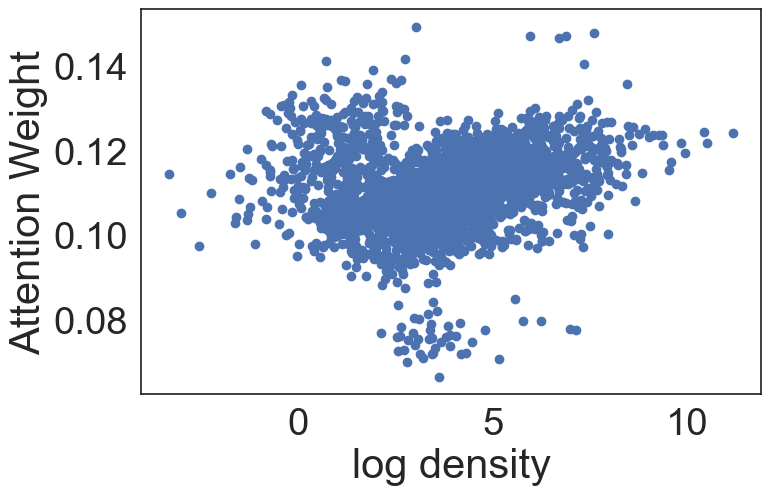

In [13]:
variable_name ='density'
plt.figure(figsize=(8, 5))
plt.scatter(np.log(df[variable_name]), df[attention_index])
plt.xlabel(f'log {variable_name}')

# plt.scatter(merged[variable_name], merged['Attention Weight'])
# plt.xlabel(variable_name)
plt.ylabel('Attention Weight')
# plt.scatter(merged[variable_name], np.log(merged['Attention Weight']))

### Scatter with distribution

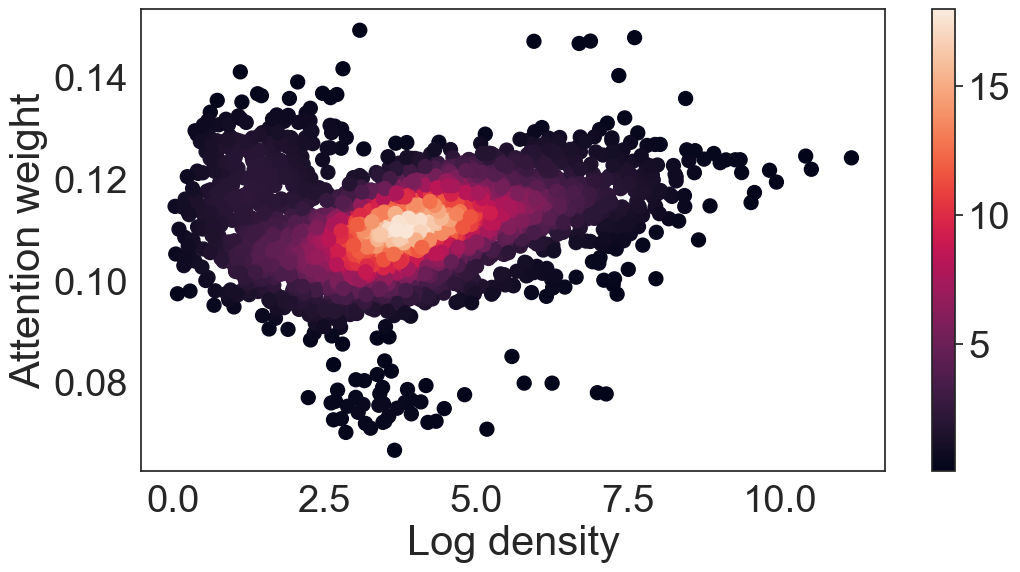

In [69]:
plt.figure(figsize=(12, 6))

x = np.log1p(df[variable_name])
y = df[attention_index]

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=z, s=100)
plt.xlabel(f'Log {variable_name}')
plt.ylabel('Attention weight')
plt.colorbar()

## Attention weights vs Cases

Text(0, 0.5, 'Attention Weight')

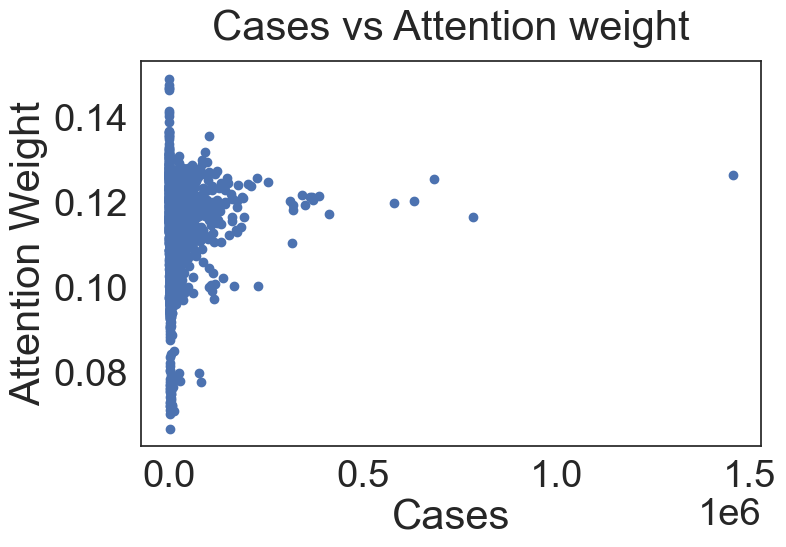

In [24]:
variable_name ='Cases'
plt.figure(figsize=(8, 5))

plt.title('Cases vs Attention weight')
plt.scatter(df[variable_name], df[attention_index])
plt.xlabel(variable_name)
# plt.xlabel(f'log {variable_name}')

plt.ylabel('Attention Weight')

Text(0, 0.5, 'Attention Weight')

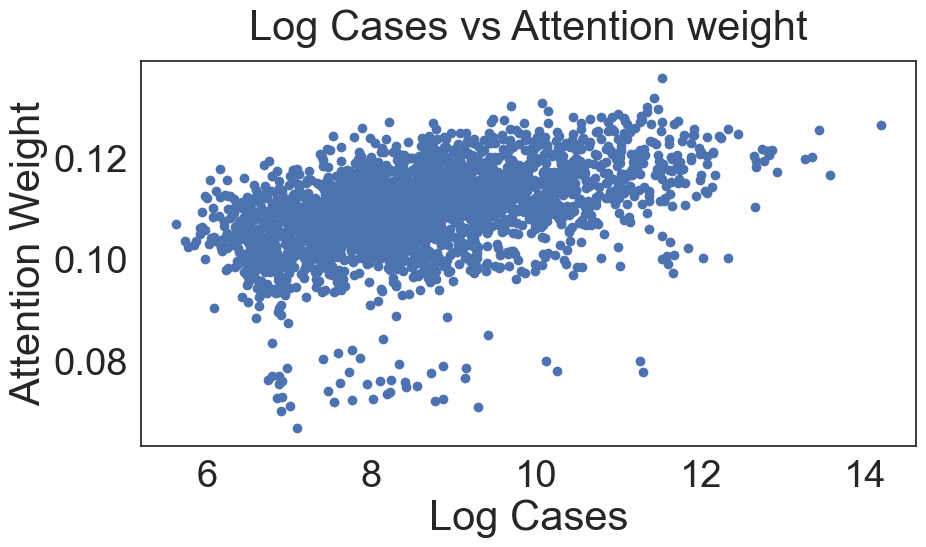

In [70]:
variable_name ='Cases'
plt.figure(figsize=(10, 5))
merged = predictions_summed_by_county[['FIPS', variable_name]].merge(
    attention_date_aligned_mean, 
    on='FIPS', how='inner'
)
merged = merged[merged[variable_name]>0]

plt.title('Log Cases vs Attention weight')
plt.scatter(np.log1p(merged[variable_name]), merged[attention_index])
plt.xlabel(f'Log {variable_name}')


plt.ylabel('Attention Weight')

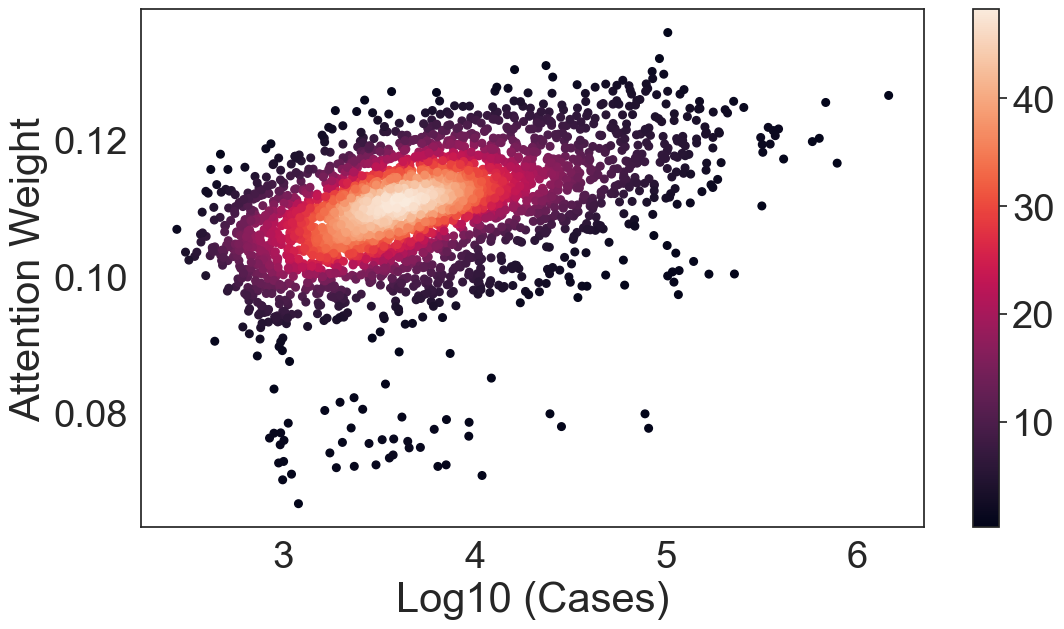

In [113]:
variable_name ='Cases'
plt.figure(figsize=(12, 7))

x = np.log1p(df[df[variable_name]>0][variable_name])
y = df[df[variable_name]>0][attention_index]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# plt.title('Log Cases vs Attention weight')
plt.scatter(x, y, c=z, s=30)
plt.xlabel(f'Log10 ({variable_name})')

plt.ylabel('Attention Weight')
plt.colorbar()
plt.tight_layout()
plt.savefig(join(root, 'Attention_scatter_plot.jpg'), dpi=200)

## Attention weights vs Cases per 100k population

In [29]:
predictions_summed_by_county['Cases by Population'] = predictions_summed_by_county['Cases']*1e5 / predictions_summed_by_county['E_TOTPOP']

Text(0, 0.5, 'Attention Weight')

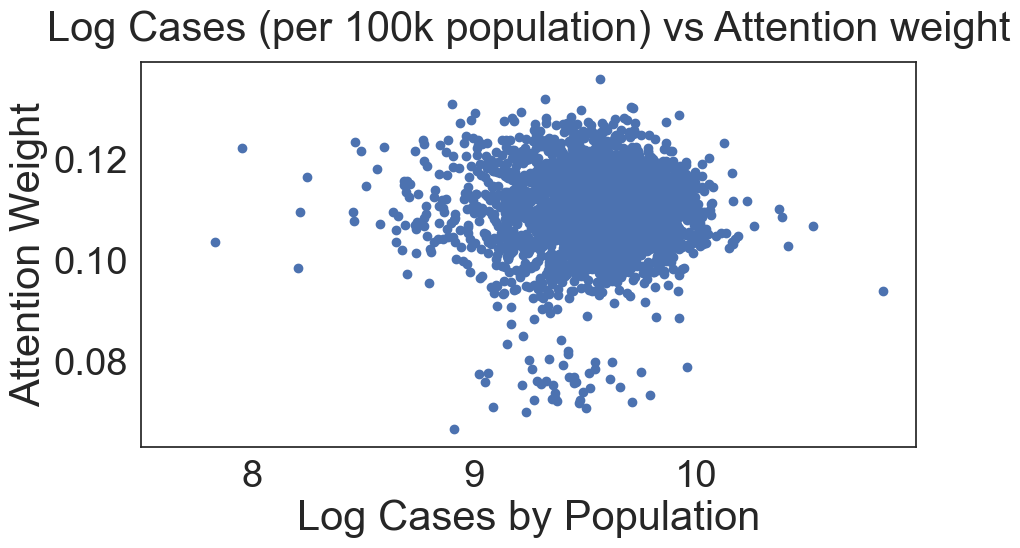

In [30]:
variable_name ='Cases by Population'
plt.figure(figsize=(10, 5))
merged = predictions_summed_by_county[['FIPS', variable_name]].merge(
    attention_date_aligned_mean, 
    on='FIPS', how='inner'
)
merged = merged[merged[variable_name]>0]
plt.title('Log Cases (per 100k population) vs Attention weight')
plt.scatter(np.log1p(merged[variable_name]), merged[attention_index])
plt.xlabel(f'Log {variable_name}')
plt.xlim(7.5)

plt.ylabel('Attention Weight')

## High vs low attention counties

Partition the counties into two groups by median attention. Then take the difference of their statistics and show the significantly different ones.

In [14]:
df['Attention Weight'] = df[attention_index].copy()
attention_median = df['Attention Weight'].median()
# partition into groups based on attention weights
higher_attention = df[df['Attention Weight']>=attention_median]
lower_attention = df[df['Attention Weight']<attention_median]

df['Class'] = 'High'
df.loc[df['Attention Weight']<attention_median, 'Class'] = 'Low'

df.describe()

,FIPS,Cases,E_TOTPOP,AREA_SQMI,density,0,1,2,3,4,5,6,7,8,9,10,11,12,mean,Attention Weight
count,3141.000000,3.141000e+03,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,30392.602674,1.446936e+04,1.039669e+05,1113.917453,272.122211,0.043483,0.018013,0.015823,0.022583,0.037600,0.072783,0.445943,0.086786,0.032944,0.022544,0.030351,0.060355,0.110675,0.076914,0.110675
std,15156.613190,4.721134e+04,3.321936e+05,3566.505526,1798.458539,0.005513,0.002839,0.002820,0.002514,0.003414,0.005666,0.015976,0.005541,0.003577,0.004096,0.004501,0.006088,0.008894,0.000095,0.008894
min,1001.000000,0.000000e+00,1.170000e+02,2.046442,0.036442,0.029410,0.011879,0.006036,0.009717,0.024982,0.052063,0.384115,0.069151,0.023855,0.006290,0.010896,0.040845,0.066614,0.076302,0.066614
25%,18179.000000,1.523000e+03,1.093400e+04,431.111302,16.568656,0.039602,0.015845,0.014175,0.021352,0.035606,0.069418,0.438360,0.083183,0.030387,0.020758,0.027885,0.056499,0.105660,0.076858,0.105660
50%,29177.000000,3.859000e+03,2.575900e+04,616.317323,44.854861,0.042888,0.017528,0.016084,0.023007,0.037432,0.072075,0.446280,0.086079,0.032713,0.023293,0.030865,0.060365,0.110840,0.076915,0.110840
75%,45081.000000,1.022300e+04,6.812300e+04,924.028576,117.639457,0.046474,0.019811,0.017750,0.024279,0.039548,0.075077,0.454275,0.090001,0.035068,0.025171,0.033716,0.064660,0.115802,0.076971,0.115802
max,56045.000000,1.457050e+06,1.004068e+07,145575.480105,71907.424647,0.071925,0.033147,0.023582,0.029655,0.051361,0.103172,0.512516,0.108802,0.048133,0.034832,0.042617,0.077328,0.149151,0.077285,0.149151


In [316]:
higher_attention['Cases'].describe()

count    1.571000e+03
mean     2.225934e+04
std      6.379829e+04
min      0.000000e+00
25%      2.332500e+03
50%      6.316000e+03
75%      1.780300e+04
max      1.457050e+06
Name: Cases, dtype: float64

In [317]:
lower_attention['Cases'].describe()

count      1570.000000
mean       6674.417675
std       16318.255919
min           0.000000
25%        1297.000000
50%        2621.750000
75%        5689.250000
max      316738.000000
Name: Cases, dtype: float64

In [15]:
merged = df.merge(
    svi[['FIPS', 'LOCATION', 'AREA_SQMI',	'E_TOTPOP']],
    on='FIPS', how='inner'
).sort_values(by='Attention Weight').reset_index(drop=True)

### Counties with least attention

In [269]:
merged[:10][['FIPS', 'LOCATION', attention_index]]

,FIPS,LOCATION,12
0,20005,"Atchison County, Kansas",0.066614
1,20107,"Linn County, Kansas",0.070116
2,20103,"Leavenworth County, Kansas",0.070753
3,20001,"Allen County, Kansas",0.070947
4,20011,"Bourbon County, Kansas",0.071895
5,20037,"Crawford County, Kansas",0.072083
6,20099,"Labette County, Kansas",0.072095
7,20051,"Ellis County, Kansas",0.072310
8,20169,"Saline County, Kansas",0.072312
9,20031,"Coffey County, Kansas",0.072589


### Counties with most attention

In [270]:
merged[-10:][['FIPS', 'LOCATION', attention_index]]

,FIPS,LOCATION,12
3131,20117,"Marshall County, Kansas",0.136757
3132,20171,"Scott County, Kansas",0.138996
3133,44007,"Providence County, Rhode Island",0.140257
3134,46089,"McPherson County, South Dakota",0.140976
3135,32029,"Storey County, Nevada",0.141590
3136,44005,"Newport County, Rhode Island",0.146555
3137,44009,"Washington County, Rhode Island",0.146979
3138,44003,"Kent County, Rhode Island",0.147019
3139,44001,"Bristol County, Rhode Island",0.147694
3140,13125,"Glascock County, Georgia",0.149151


## SVI differences

### Merge attention with SVI

In [46]:
# merge the attentions with the SVI features
higher_merged = higher_attention.merge(svi, on='FIPS', how='inner')
lower_merged = lower_attention.merge(svi, on='FIPS', how='inner')

# select the socio-economic features with percentage 
higher_stats = higher_merged[[col for col in svi.columns if col.startswith('EPL_')]].describe()
lower_stats = lower_merged[[col for col in svi.columns if col.startswith('EPL_')]].describe()

diff = higher_stats - lower_stats
diff

,EPL_POV150,EPL_UNEMP,EPL_HBURD,EPL_NOHSDP,EPL_UNINSUR,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_LIMENG,EPL_MINRTY,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,-0.092483,-0.022090,0.158797,-0.071260,-0.080097,-0.055843,-0.014471,-0.098260,0.010696,0.052828,0.013707,0.111518,-0.116920,-0.031839,0.002334,-0.009047
std,0.011018,-0.010591,0.058877,-0.008639,0.016674,-0.001631,-0.018707,-0.001398,-0.010668,-0.001046,-0.003191,0.022788,0.016474,0.000485,0.010215,-0.002948
min,-0.001000,0.000000,-0.001300,-0.000600,-0.000600,-0.000300,-0.000600,0.000300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.118400,0.000000,0.135600,-0.060800,-0.134300,-0.067800,0.014100,-0.108600,0.053500,0.081200,0.027700,0.111100,-0.150075,0.000000,0.000000,0.000000
50%,-0.134700,-0.021300,0.260400,-0.112700,-0.129800,-0.087200,-0.027400,-0.141000,0.020000,0.085300,0.022900,0.156200,-0.174100,-0.098100,0.000000,-0.022300
75%,-0.089100,-0.053800,0.231800,-0.090700,-0.042400,-0.069025,-0.028000,-0.127000,0.000000,0.048400,0.006800,0.152800,-0.106000,-0.031600,0.030800,-0.007700
max,-0.001300,0.001900,0.005700,0.000300,-0.000600,-0.000300,0.000300,0.000600,-0.001600,-0.000600,0.000300,0.003500,-0.001000,0.000300,0.000600,0.000300


In [47]:
# features with significant median difference in socio-economic scales
threshold = 0.13
diff.loc[:, abs(diff.loc['50%'].round(2))>=threshold]

,EPL_POV150,EPL_HBURD,EPL_UNINSUR,EPL_DISABL,EPL_MUNIT,EPL_MOBILE
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,-0.092483,0.158797,-0.080097,-0.098260,0.111518,-0.116920
std,0.011018,0.058877,0.016674,-0.001398,0.022788,0.016474
min,-0.001000,-0.001300,-0.000600,0.000300,0.000000,0.000000
25%,-0.118400,0.135600,-0.134300,-0.108600,0.111100,-0.150075
50%,-0.134700,0.260400,-0.129800,-0.141000,0.156200,-0.174100
75%,-0.089100,0.231800,-0.042400,-0.127000,0.152800,-0.106000
max,-0.001300,0.005700,-0.000600,0.000600,0.003500,-0.001000


In [48]:
significantly_different_columns = list(
    diff.loc[:, abs(diff.loc['50%'].round(2))>=threshold].columns
)
print(significantly_different_columns)
significantly_different_columns = ['EPL_POV150', 'EPL_HBURD', 'EPL_UNINSUR']

merged = df.merge(
    svi[['FIPS']+significantly_different_columns], 
    on='FIPS', how='inner'
)

['EPL_POV150', 'EPL_HBURD', 'EPL_UNINSUR', 'EPL_DISABL', 'EPL_MUNIT', 'EPL_MOBILE']


In [49]:
merged2 = []
for col in significantly_different_columns:
    temp = pd.DataFrame({
        'Class': merged['Class'],
        'Feature': col,
        'Value': merged[col]
    })

    merged2.append(temp)

merged2 = pd.concat(merged2, axis=0)

### Boxplot

In [312]:
merged2.replace(
    {
    # 'EPL_POV150':'Poverty', 'EPL_DISABL':'Disability', 
    #  'EPL_HBURD':'Burdened', 'EPL_MUNIT': 'Units', 'EPL_MOBILE':'Mobile Home'
    'EPL_POV150':'Poverty', 'EPL_HBURD':'Burdened', 'EPL_UNINSUR':'Uninsured'
    }, inplace=True
)

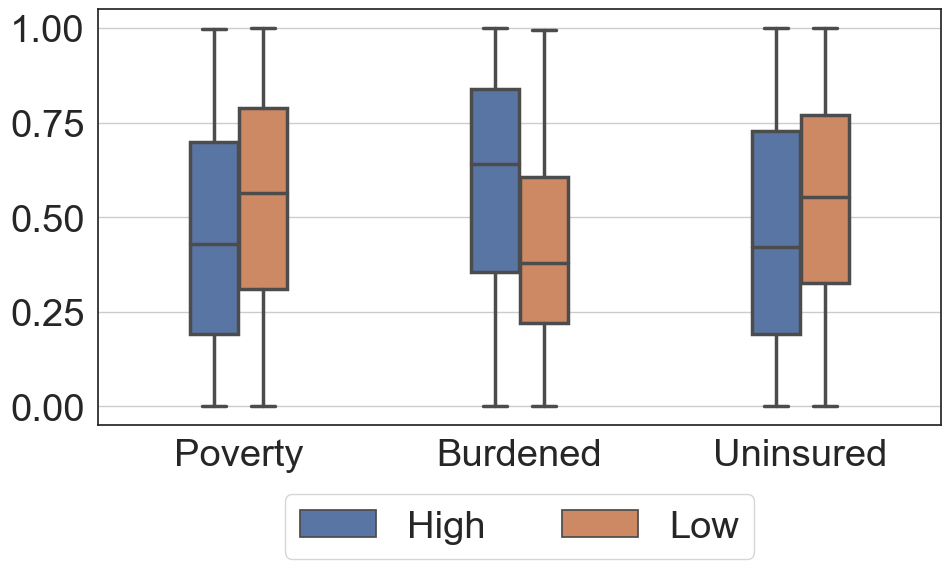

In [314]:
plt.figure(figsize=(10, 6.5))
sns.boxplot(
    x = 'Feature', y = 'Value', hue='Class', 
    data = merged2, linewidth=2.5, width=0.35,
    hue_order=['High', 'Low']
)
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.12),fancybox=True)
plt.tight_layout()
plt.savefig(join(root, 'Attention_comparison_SVI.jpg'), dpi=200)

## Map
Download the latest county and state shape files from [here](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html).

## Imput shapes

In [17]:
import geopandas

### State

In [18]:
states = geopandas.read_file(
    '../../dataset_additional/Shapes/cb_2021_us_state_5m/cb_2021_us_state_5m.shp'
)

# remove the states those are scatter outside the connected landscape for better map
scattered_states = ['HI', 'AK', 'PR', 'MP', 'GU', 'AS', 'VI']
states =states[~states['STUSPS'].isin(scattered_states)]
# states = states.to_crs("EPSG:3395")
states.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
1,22,01629543,0400000US22,22,LA,Louisiana,00,111915258185,23736382213,"MULTIPOLYGON (((-88.88145 30.05320, -88.87048 ..."
2,24,01714934,0400000US24,24,MD,Maryland,00,25151992308,6979074857,"MULTIPOLYGON (((-76.04862 38.01484, -76.04621 ..."


In [73]:
states[states['STUSPS'].isin()]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
2,24,01714934,0400000US24,24,MD,Maryland,00,25151992308,6979074857,"MULTIPOLYGON (((-76.04862 38.01484, -76.04621 ..."
6,25,00606926,0400000US25,25,MA,Massachusetts,00,20204390225,7130660432,"MULTIPOLYGON (((-70.27553 41.31046, -70.26063 ..."
16,33,01779794,0400000US33,33,NH,New Hampshire,00,23190115212,1025971768,"POLYGON ((-72.55506 42.85812, -72.55423 42.860..."
22,09,01779780,0400000US09,09,CT,Connecticut,00,12541690473,1816424193,"POLYGON ((-73.72777 41.10070, -73.69595 41.115..."
23,34,01779795,0400000US34,34,NJ,New Jersey,00,19048916230,3533083369,"POLYGON ((-75.55910 39.62906, -75.55945 39.629..."
30,50,01779802,0400000US50,50,VT,Vermont,00,23872569964,1030754609,"POLYGON ((-73.43774 44.04501, -73.43199 44.063..."
31,44,01219835,0400000US44,44,RI,Rhode Island,00,2677763359,1323686988,"MULTIPOLYGON (((-71.36152 41.46483, -71.34707 ..."
54,10,01779781,0400000US10,10,DE,Delaware,00,5046731559,1399179670,"MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ..."


### Counties

In [19]:
counties = geopandas.read_file(
    '../../dataset_raw/Shapes/cb_2021_us_county_5m/cb_2021_us_county_5m.shp'
)
# counties = counties.to_crs("EPSG:3395")
counties.head(2)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,01,059,00161555,0500000US01059,01059,Franklin,Franklin County,AL,Alabama,06,1641845708,32639621,"POLYGON ((-88.16591 34.38093, -88.16563 34.383..."
1,06,057,01682927,0500000US06057,06057,Nevada,Nevada County,CA,California,06,2480587301,41531993,"POLYGON ((-121.27953 39.23054, -121.25918 39.2..."


In [20]:
counties = counties[counties['STUSPS'].isin(states['STUSPS'])]
counties['GEOID'] = counties['GEOID'].astype(str).astype(int)

## Attention Weights

In [21]:
counties = counties.merge(
    df, left_on='GEOID', 
    right_on='FIPS', how='inner'
).reset_index()

### Continuous plot

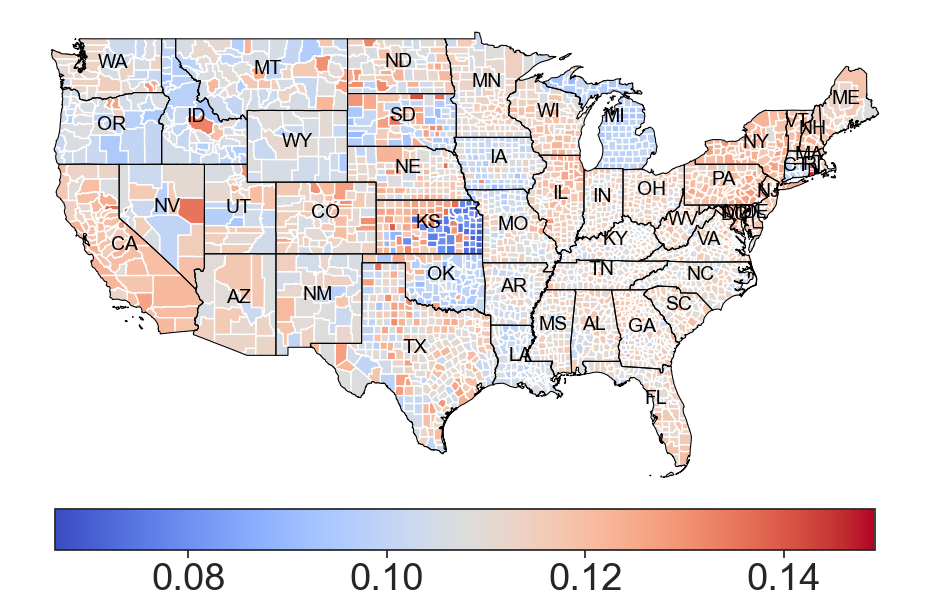

In [156]:
# https://www.python-graph-gallery.com/choropleth-map-geopandas-python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

states.apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=12, color='black'
    ),axis=1
)

states.boundary.plot(ax=ax, color='Black', linewidth=0.8)

# this is to ensure color map legend stays within figure
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.colorbar
counties.plot(
    attention_index, ax=ax, cmap='coolwarm',
    legend=True, # scheme='QUANTILES', k=2, cax=cax, alpha=0.6,
    legend_kwds={
        # 'label': "Attention Weight", 
        'location':'bottom', 'orientation': 'horizontal', 
        'pad':0.01, 'shrink':0.9
    }
)
# ax.add_artist(ScaleBar(1, units='km'))
ax.axis('off')
fig.tight_layout()
fig.savefig(join(root, 'maps/attention_continuous_coolwarm.jpg'), dpi=200, bbox_inches="tight")

### Discrete plot

In [22]:
# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html
cmap = mpl.colors.ListedColormap(["lightgrey", "lightblue" , "pink","maroon"])

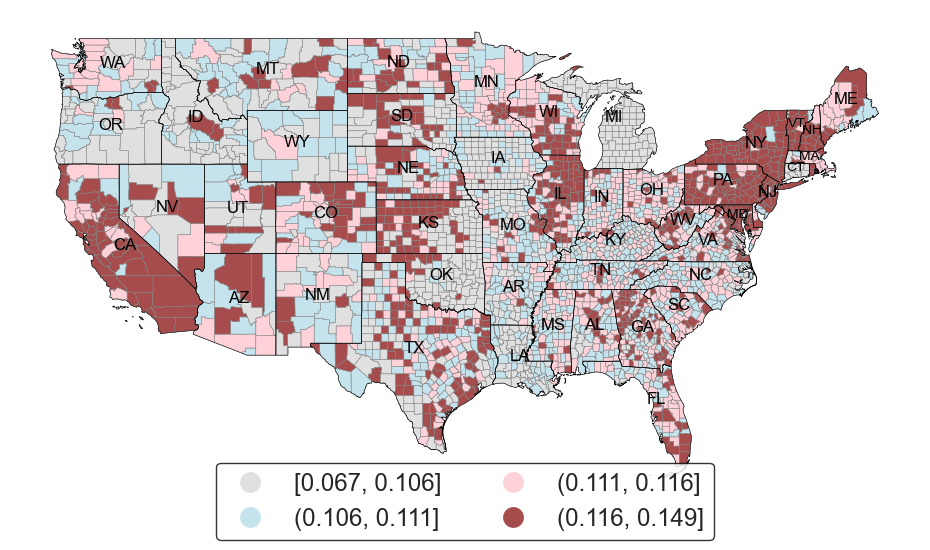

In [125]:
# https://www.python-graph-gallery.com/choropleth-map-geopandas-python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# congested_states = ['DE', 'MD', 'NJ', 'RI', 'MA', 'CT', 'NH', 'VT', 'DC']
smaller_states = ['MA', 'CT', 'MD', 'NH', 'VT']
smallest_states = ['DE', 'RI','DC']
congested_states = smaller_states + smallest_states
states[~states['STUSPS'].isin(congested_states)].apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=12, color='black'
    ),axis=1
)
states[states['STUSPS'].isin(smaller_states)].apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=10, color='black'
    ),axis=1
)

counties.boundary.plot(ax=ax, color='grey', linewidth=0.3)
states.boundary.plot(ax=ax, color='black', linewidth=0.4)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
counties.plot(
    attention_index, ax=ax, scheme='QUANTILES', k=4, 
    legend=True, cmap=cmap, linewidth=0.01, alpha=0.7,
    legend_kwds={
        # 'title':'Attention Weight', # it is title when scheme is quantiles
        'loc':'upper center', 'fontsize':'xx-small', 'title_fontsize': 'x-small', 
        'interval':True, 'bbox_to_anchor':(0.5, 0.1), 'ncols':2,
        'fmt':"{:.3f}", 'edgecolor':'black', 'markerscale':1.5}
)
ax.axis('off')
# ax.add_artist(ScaleBar(1, units='km'))

fig.tight_layout()
fig.savefig(join(root, 'maps/attention_quantiles.jpg'), dpi=200, bbox_inches="tight")

## Cases

### Discrete map

#### Cumulative Cases

In [118]:
counties['log_Cases'] = counties['Cases'].apply(np.log1p)

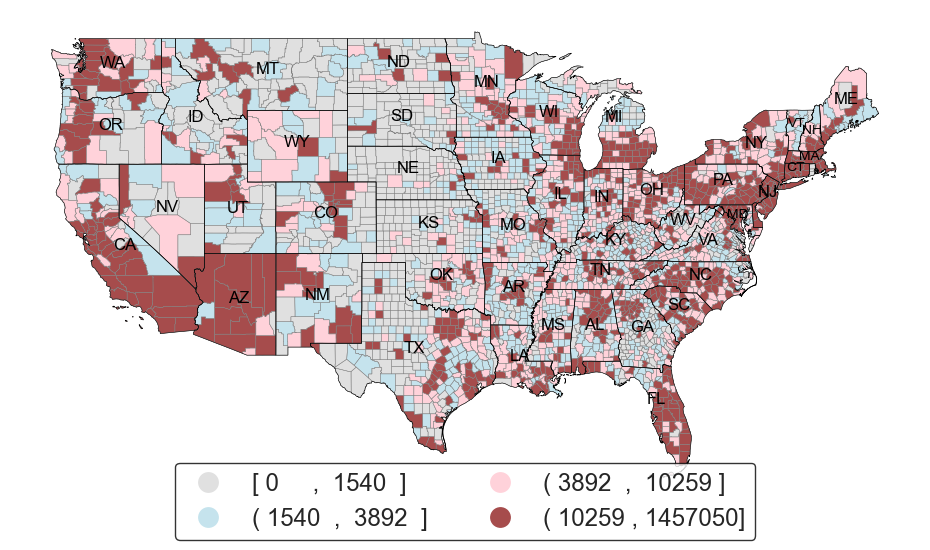

In [126]:
# https://www.python-graph-gallery.com/choropleth-map-geopandas-python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

states[~states['STUSPS'].isin(congested_states)].apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', 
        fontsize=12, color='black'
    ),axis=1
)
states[states['STUSPS'].isin(smaller_states)].apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', 
        fontsize=10, color='black'
    ),axis=1
)

counties.boundary.plot(ax=ax, color='grey', linewidth=0.3)
states.boundary.plot(ax=ax, color='black', linewidth=0.4)


# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html
# cmap = mpl.colors.ListedColormap(["lightgrey", "lightblue" , "pink","maroon"])

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
counties.plot(
    'Cases', ax=ax, cmap=cmap, scheme='QUANTILES', 
    alpha=.7, k=4, linewidth=0.01, legend=True, # cax=cax, 
    legend_kwds={
        # 'title': "Cumulative COVID-19 cases (per 100K people)",
        'loc':'upper center', 'fontsize':'xx-small', 
        'title_fontsize': 'x-small', 'interval':True, 
        'bbox_to_anchor':(0.5, 0.1), 'ncols':2 , 'fmt':"{:<6.0f}"
        , 'edgecolor':'black', 'markerscale':1.5
    }
)
ax.axis('off')
# ax.add_artist(ScaleBar(1, units='km'))
fig.tight_layout()
fig.savefig(join(root, 'maps/cases_quantiles.jpg'), dpi=200, bbox_inches="tight")

#### Cases by 100k Population

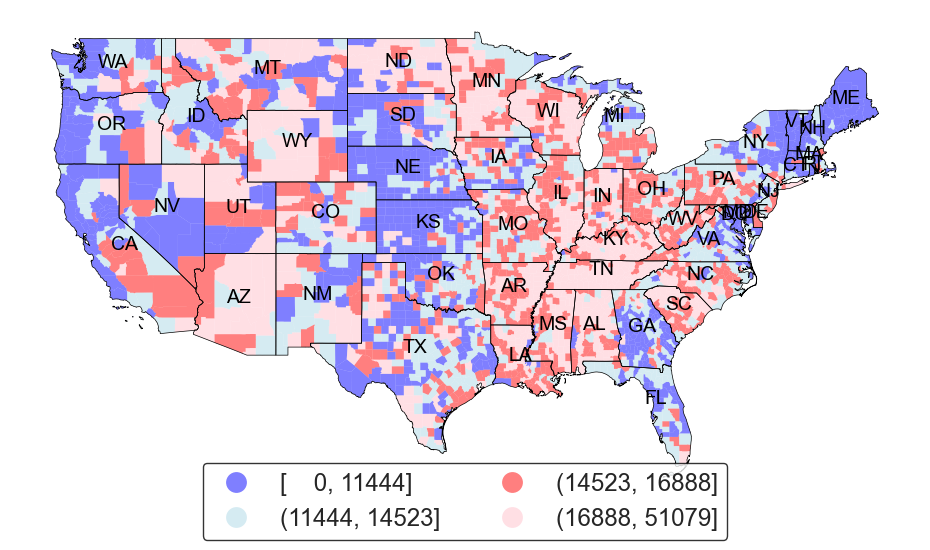

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

states.apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=14, color='black'
    ),axis=1
)

states.boundary.plot(ax=ax, color='black', linewidth=0.5)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
counties.plot(
    'Cases by Population', ax=ax, cmap='coolwarm', scheme='QUANTILES', 
    alpha=0.5, k=4, linewidth=0.01, legend=True, # cax=cax, 
    legend_kwds={
        # 'title': "Cumulative COVID-19 cases (per 100K people)",
        'loc':'upper center', 'fontsize':'xx-small', 'title_fontsize': 'x-small', 
        'interval':True, 'bbox_to_anchor':(0.5, 0.1), 'ncols':2, 
        'fmt':"{:.0f}", 'edgecolor':'black', 'markerscale':1.5
    }
)
ax.axis('off')
# ax.add_artist(ScaleBar(1, units='km'))
fig.tight_layout()
# fig.savefig(join(root, 'maps/cases_by_population_quantiles_coolwarm.jpg'), dpi=200, bbox_inches="tight")

### Continuous map

In [136]:
counties['log1p Cases by Population'] = counties['Cases by Population'].apply(np.log1p)
counties['log1p Cases'] = counties['Cases'].apply(np.log1p)

#### Log1p of Cases

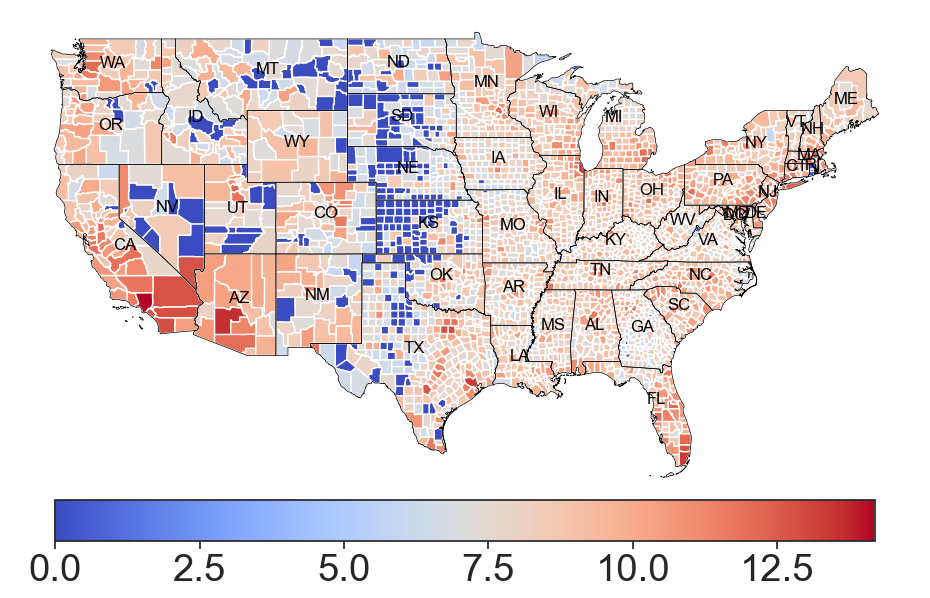

In [184]:
# https://www.python-graph-gallery.com/choropleth-map-geopandas-python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

states.apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=12, color='black'
    ),axis=1
)

states.boundary.plot(ax=ax, color='black', linewidth=0.5)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.01)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.colorbar
counties.plot(
    'log1p Cases', ax=ax, cmap='coolwarm', # cax=cax,
    legend=True, legend_kwds={
        # 'label': "Log1p of cumulative COVID-19 cases",
        'orientation': 'horizontal', 'pad':0, 'shrink':0.9
    }
)
ax.axis('off')
# ax.add_artist(ScaleBar(1, units='km'))
fig.tight_layout()
fig.savefig(join(root, 'maps/log1p_cases_continuous.jpg'), dpi=200, bbox_inches="tight")

#### Log1p of Cases per 100k population

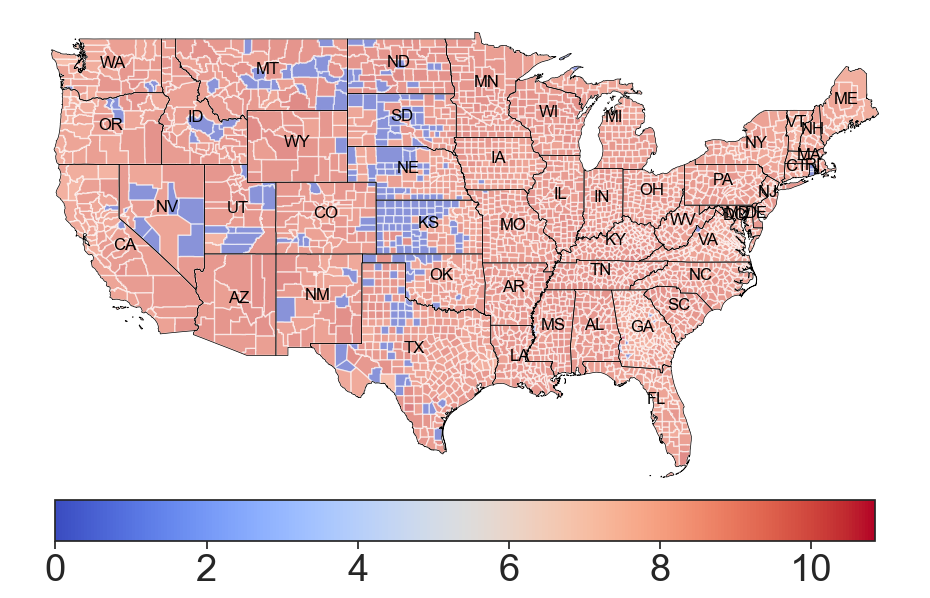

In [183]:
# https://www.python-graph-gallery.com/choropleth-map-geopandas-python
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

states.apply(
    lambda x: ax.annotate(text=x.STUSPS, 
        xy=x.geometry.centroid.coords[0], ha='center', fontsize=12, color='black'
    ),axis=1
)

states.boundary.plot(ax=ax, color='black', linewidth=0.5)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.01)

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
counties.plot(
    'log1p Cases by Population', ax=ax, cmap='coolwarm', # cax=cax,
    alpha=0.6,
    legend=True, legend_kwds={
        # 'label': "Log1p of cumulative COVID-19 cases \n(per 100K population)",
        'orientation': 'horizontal', 'pad':0,'shrink':0.9
    }
)
ax.axis('off')

# https://pypi.org/project/matplotlib-scalebar/
# ax.add_artist(ScaleBar(1, units='km'))
fig.tight_layout()
fig.savefig(join(root, 'maps/log1p_cases_by_population_continuous.jpg'), dpi=200, bbox_inches="tight")